In [78]:
import os
import pickle
import csv
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
from statsmodels.api import OLS
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import chain

In [79]:
dir = os.getcwd()
data_dir = dir+"/data/"

# Load test results
data = []
data_file = data_dir+"tap_consistency.csv"
with open(data_file) as results:
    reader = csv.reader(results)
    for row in reader:
        data.append(row)
    results.close()

data = np.asarray(data, dtype=float)
print(data.shape)

(43, 96)


In [80]:
## Define some things
n_subjects = len(data)
test_length = 32
n_tests = 3

# Each test has n subjects each doing 32 taps
# 0 = low midi=[0,42]
# 1 = hi  midi=(42,84]
# 2 = mid midi=(84,127]
tap_by_test = np.array([[[0.0 for x in range(test_length)] for y in range(n_subjects)] for z in range(n_tests)], dtype=float)

# Each subject has 3 tests of 32 taps
tap_by_subject = np.array([[[0.0 for x in range(test_length)] for y in range(n_tests)] for z in range(n_subjects)], dtype=float)

# Fill the arrays
for subj in range(n_subjects):
    line = data[subj] # 96 long (32 x 3)
    for test in range(n_tests): # 3
        tap_by_test[test][subj] = line[test*32:(test+1)*32]
        tap_by_subject[subj][test]= line[test*32:(test+1)*32]

In [81]:
## Plotstyles for Consistency ##
## Labels and Titles ##
title_style={ 
    'fontsize':14,
    'fontfamily':'serif',
    'fontweight':'book'
}
label_style={
    'fontsize':12,
    'fontfamily':'sans-serif',
    'fontweight':'book'
}
## Scatters -----------
scatter_style={
    'color':'dimgrey',
    'marker':'.',
    'linewidth':0.5,
    'alpha':0.6
}
tap_scatter_style={
    'marker':'x',
    'linestyle':'--',
    'linewidth':1,
    'alpha':0.8
}
## Lines -----------
dashed_line_style={
    'color':'dimgrey',
    'linestyle':'--',
    'alpha':0.8,
    'linewidth':0.8
}
solid_line_style={
    'color':'dimgrey',
    'linestyle':'-',
    'alpha':0.9,
    'linewidth':0.8
}

colors_light=['lightgreen','lightblue','mediumpurple']
colors_dark=['forestgreen', 'royalblue','indigo']

## Boxplots -----------
box_style={
    "patch_artist":True,
    "showfliers":True,
    "widths":0.25,
    "medianprops":{"color":'black'}
}
boxf_style={
    "marker":'x', 
    "markersize":'5',
    "alpha":0.6
}
boxb_style={
    "alpha":0.8,
    "facecolor":'lightgrey',
    "linewidth":0.8

}

box_style2={
    "widths":0.6,
    "patch_artist":True,
    "medianprops":{"color":'black'}
}

mpl.rcParams['hatch.linewidth'] = 2
mpl.rcParams['hatch.color'] = 'black'


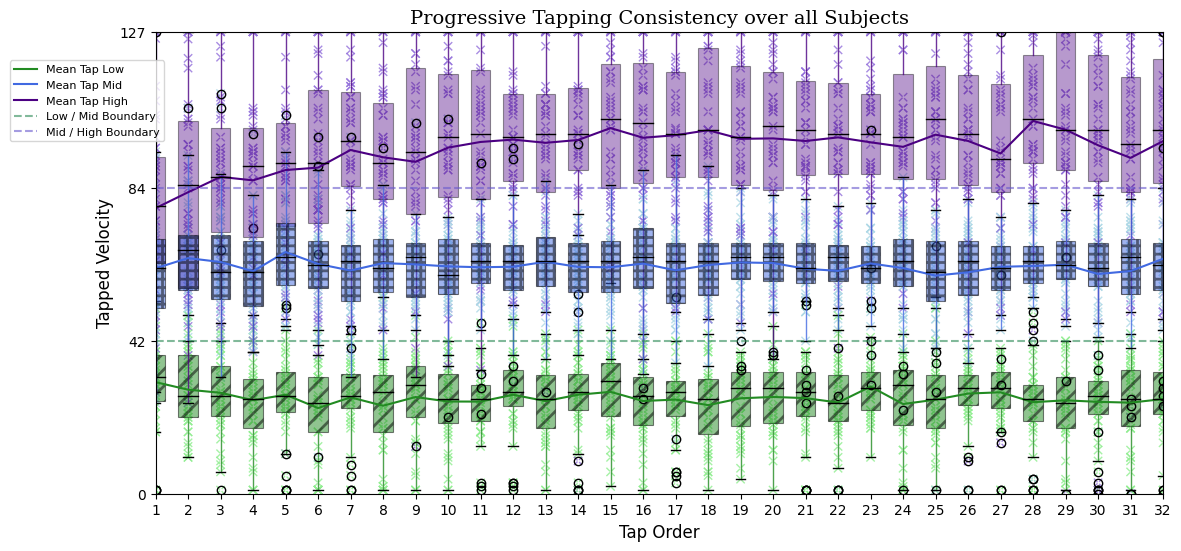

In [82]:
## Graph over Time
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot()

index = np.arange(test_length)+1

low = tap_by_test[0]
mid = tap_by_test[2]
high= tap_by_test[1]

for i in range(n_subjects):
    ax.scatter(index, low[i,:], color=colors_light[0], **tap_scatter_style)
    ax.scatter(index, mid[i,:], color=colors_light[1], **tap_scatter_style)
    ax.scatter(index, high[i,:], color=colors_light[2], **tap_scatter_style)

bp_low = ax.boxplot(low, boxprops={**boxb_style,'facecolor':colors_dark[0], "alpha":0.5, "hatch":"//"}, whiskerprops={"color":colors_dark[0], "alpha":0.8}, **box_style2)
bp_high = ax.boxplot(high, boxprops={**boxb_style,'facecolor':colors_dark[2], "alpha":0.4}, whiskerprops={"color":colors_dark[2], "alpha":0.8},**box_style2)
bp_mid = ax.boxplot(mid, boxprops={**boxb_style,'facecolor':colors_dark[1], "alpha":0.5, "hatch":"++"}, whiskerprops={"color":colors_dark[1], "alpha":0.8},**box_style2)

ax.plot(index, np.mean(low, axis=0), color=colors_dark[0], label="Mean Tap Low")
ax.plot(index, np.mean(mid, axis=0), color=colors_dark[1], label="Mean Tap Mid")
ax.plot(index, np.mean(high, axis=0), color=colors_dark[2], label="Mean Tap High")


ax.axhline(y=42,color='seagreen', alpha=0.6, linestyle='--', label='Low / Mid Boundary')
ax.axhline(y=84,color='slateblue', alpha=0.6, linestyle='--', label='Mid / High Boundary')

ax.set(ylim=[0,127], yticks=[0,42,84,127], xlim=[1,32],xticks=index)
ax.set_title(f"Progressive Tapping Consistency over all Subjects", fontsize=14, fontfamily='serif',fontweight='book')
ax.set_xlabel("Tap Order", fontsize=12, fontfamily='sans-serif')
ax.set_ylabel("Tapped Velocity", fontsize=12, fontfamily='sans-serif')
plt.legend(loc='upper left', bbox_to_anchor=(-0.15, 0.95),prop={'size': 8})
plt.show()


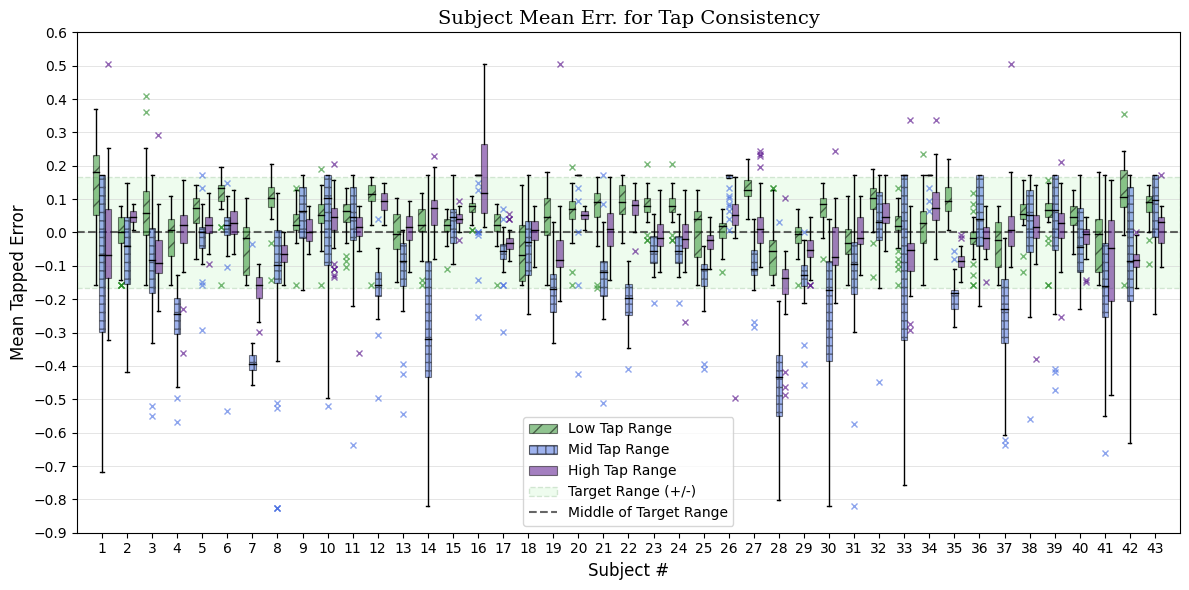

In [84]:
## Graph by Subject ##

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot()
subjidx = np.arange(n_subjects)+1
ax.grid(color='lightgray', linestyle='-', linewidth=0.6, alpha=0.7, axis='y')

# shift for 3x boxplot
pos_low = subjidx - 0.25
pos_high = subjidx + 0.25

# target rectangle
line = ax.axhline(y=0,color='black', alpha=0.6, linestyle='--', label='Middle of Target Range')
p1 = (n_subjects+1,-float(0.33/2))
p2 = (0.0,float(0.33/2))
rect = mpl.patches.Rectangle((p2[0], p1[1]), p1[0] - p2[0], p2[1] - p1[1], linewidth=1, edgecolor='darkgreen', facecolor='lightgreen', alpha=0.15, linestyle='--', label='Target Range (+/-)')
ax.add_patch(rect)

# make a copy and normalize to middle of target range
_tap_by_test=tap_by_test.copy()
for i in range(n_subjects):
    _tap_by_test[0][i] = (tap_by_test[0][i]-21) / 127
    _tap_by_test[1][i] = (tap_by_test[1][i]-105) / 127
    _tap_by_test[2][i] = (tap_by_test[2][i]-63) / 127

mpl.rcParams['hatch.linewidth'] = 1
bp1_low = ax.boxplot(_tap_by_test[0].T, positions=pos_low, **box_style, boxprops={**boxb_style,"facecolor":colors_dark[0], "alpha":0.5, "hatch":"//"}, flierprops={"markeredgecolor":colors_dark[0], **boxf_style})
bp1_mid = ax.boxplot(_tap_by_test[1].T, positions=subjidx, **box_style, boxprops={**boxb_style,"facecolor":colors_dark[1], "alpha":0.5, "hatch":"++"}, flierprops={"markeredgecolor":colors_dark[1], **boxf_style})
bp1_high = ax.boxplot(_tap_by_test[2].T, positions=pos_high, **box_style, boxprops={**boxb_style,"facecolor":colors_dark[2], "alpha":0.5}, flierprops={"markeredgecolor":colors_dark[2], **boxf_style})

ax.set(xlim=[0,n_subjects+1], ylim=[-0.9,0.6], xticks=subjidx, xticklabels=subjidx, yticks=np.arange(start=-0.9,stop=0.7,step=0.1))

ax.set_title(f"Subject Mean Err. for Tap Consistency", fontsize=14, fontfamily='serif',fontweight='book')
ax.set_xlabel("Subject #", fontsize=12, fontfamily='sans-serif')
ax.set_ylabel("Mean Tapped Error", fontsize=12, fontfamily='sans-serif')

# Add and Remove the dummy lines to make legend work
line1, = ax.plot([1,1], color='blue')
line2, = ax.plot([1,1], color='green')
line3, = ax.plot([1,1], color='red')
line1.set_visible(False)
line2.set_visible(False)
line3.set_visible(False)

ax.legend([bp1_low["boxes"][0], bp1_mid["boxes"][0], bp1_high["boxes"][0], rect, line], ('Low Tap Range', 'Mid Tap Range', 'High Tap Range', 'Target Range (+/-)', 'Middle of Target Range'))
fig.tight_layout()
plt.show()


In [149]:
## Quartile and Test Level Statistics ##
pd.set_option('display.float_format', '{:.4f}'.format)
np.set_printoptions(precision=4)

neutral = np.zeros((n_subjects,32))
# ANOVA Test level
for i in range(3):
    anova = stats.f_oneway(np.mean(neutral, axis=0),np.mean(_tap_by_test[i][:], axis=0))
    print(f"Tap Consistency F-Stat: {anova.statistic:.4f} P-Value: ({anova.pvalue:.8f}) {i}")
#anova = stats.f_oneway(np.mean(_tap_by_test[0][:], axis=0), np.mean(_tap_by_test[1][:], axis=0), np.mean(_tap_by_test[2][:], axis=0))


# Tukey's HSD

Tap Consistency F-Stat: 374.9295 P-Value: (0.00000000) 0
Tap Consistency F-Stat: 120.4210 P-Value: (0.00000000) 1
Tap Consistency F-Stat: 3.2484 P-Value: (0.07635279) 2


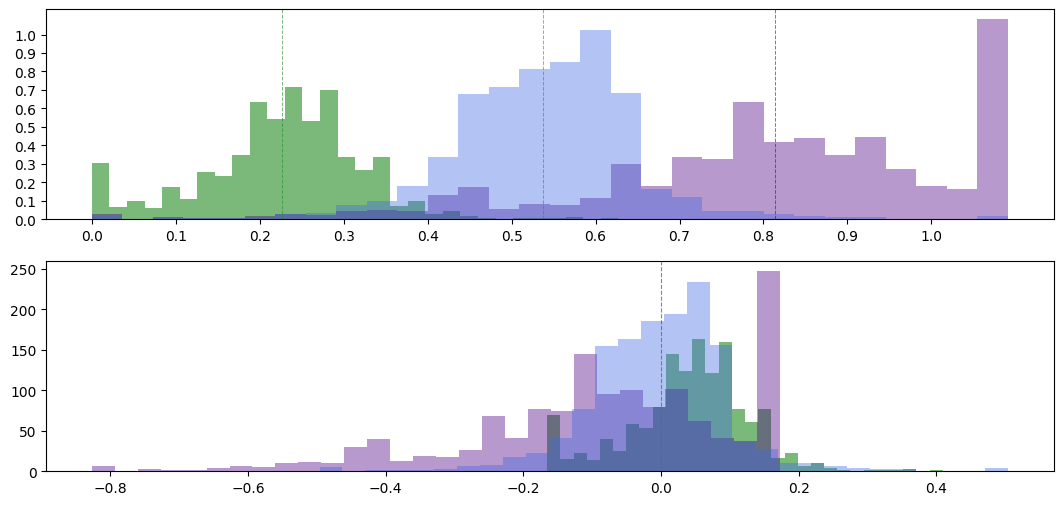

In [144]:
fig, ax = plt.subplots(2,1,figsize=(13,6))
test_low = tap_by_test[0].flatten()
test_mid = tap_by_test[1].flatten()
test_high = tap_by_test[2].flatten()
ax[0].hist(test_low, bins=30, alpha=0.6, color=colors_dark[0])
ax[0].hist(test_mid, bins=30, alpha=0.4, color=colors_dark[2])
ax[0].hist(test_high, bins=30, alpha=0.4, color=colors_dark[1])

# axis label chicanery
ax[0].set(xticks=np.arange(0, 128, np.round(128/11,2)), xticklabels=[str(t) for t in np.round(np.arange(0,1.1,0.1),2)])
ax[0].set(yticks=np.arange(0,251,np.round(251/11,2)), yticklabels=[str(t) for t in np.round(np.arange(0, 1.1, 0.1),2)])
#ax[0].axhline(y=(np.round(251/11,2)*5),color='black', alpha=0.6, linestyle='--', linewidth=0.7)
ax[0].axvline(x=np.mean(test_low), alpha=0.6, linestyle='--', linewidth=0.7, color=colors_dark[0])
ax[0].axvline(x=np.mean(test_mid), alpha=0.6, linestyle='--', linewidth=0.7, color=colors_dark[2])
ax[0].axvline(x=np.mean(test_high), alpha=0.6, linestyle='--', linewidth=0.7, color=colors_dark[1])



test_low = _tap_by_test[0].flatten()
test_mid = _tap_by_test[1].flatten()
test_high = _tap_by_test[2].flatten()
ax[1].hist(test_low, bins=30, alpha=0.6, color=colors_dark[0])
ax[1].hist(test_mid, bins=30, alpha=0.4, color=colors_dark[2])
ax[1].hist(test_high, bins=30, alpha=0.4, color=colors_dark[1])
ax[1].axvline(x=0.0, **dashed_line_style)
plt.show()